In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib.tri import Triangulation

from shapely.geometry import Polygon
import pyproj
import datetime as dt
import pandas as pd
from osgeo import gdal

from nansat import Nansat, Domain, NSR, Figure

from sea_ice_drift import get_n
from sea_ice_drift.lib import get_spatial_mean
from sea_ice_drift.ftlib import feature_tracking
from sea_ice_drift.pmlib import pattern_matching

%matplotlib inline

In [2]:
def get_nansat(f):
    """
    Returns:
    --------
    nft : nansat.Nansat
        sigma0_HH with spatial mean removed (helps feature tracking and plotting)
    npm: nansat.Nansat
        sigma0_HH without spatial mean removed (so pattern matching doesn't crash)
    """
    if 0:
        n = get_n(f, bandName='sigma0_HH', remove_spatial_mean=True)
        return n, n
    n = Nansat(f)
    start = n.time_coverage_start
    ds = gdal.Open(n.filename+'/imagery_HH.tif')
    hh = ds.ReadAsArray()
    npm = Nansat.from_domain(n, array=hh)
    hh -= get_spatial_mean(hh).astype('uint8') #remove mean
    nft = Nansat.from_domain(n, array=hh)
    for n in [nft, npm]:
        n.set_metadata(dict(time_coverage_start=start))
    return nft, npm

In [3]:
def get_bbox_approx():
    lon, lat = np.array([
        (-109.4, 74.7), # TR
        (-118.8, 67.5), # BR
        (-161.3, 70.5), # BL: Barrow
        (-153.9, 75.8), # TL
        ]).T
    return lon, lat

In [4]:
def get_proj():
    lon, lat = get_bbox_approx()
    lonc, latc = lon.mean() -2, lat.mean()
    lat_ts = latc
    srs = f'+proj=stere +lat_0={latc} +lat_ts={latc} +lon_0={lonc} +x_0=0 +y_0=0 +a=6378273 +b=6356889.44891059 +units=m +no_defs'
    return pyproj.Proj(srs)

In [5]:
def get_bbox(proj):
    lon, lat = get_bbox_approx()
    x, y = proj(lon, lat)
    xav, yav = np.mean(x), np.mean(y)
    dx = x.max() - x.min()
    dy = y.max() - y.min()
    factor = 1.4
    return xav - factor*dx/2, xav + factor*dx/2, yav - factor*dy/2, yav + factor*dy/2

In [6]:
# image in stereographic projection
def get_projected_hh(n, d, **kwargs):
    n.reproject(d, **kwargs)
    n1_hh_pro = n[1]
    n.undo()
    return n1_hh_pro.astype(float)

# Deformation code
From https://github.com/nansencenter/nextsim-tools/blob/master/python/pynextsim/lib.py

In [7]:
def get_deformation_elems(x, y, u, v, a):
    """ Compute deformation for given elements.
    Input X, Y, U, V are organized in three columns: for each node of M elements.
    To convert deformation rates from 1/s to %/day outputs should be multiplied by 8640000.
    Parameters
    ----------
    x : 3xM ndarray
        X-coordinates of nodes, m
    y : 3xM ndarray
        Y-coordinates of nodes, m
    u : 3xM ndarray
        U-component of nodes, m/s
    v : 3xM ndarray
        V-component of nodes, m/s
    a : Mx1 ndarray
        area of elements, m2
    Returns
    -------
    e1 : Mx1 array
        Divergence, 1/s
    e2 : Mx1 array
        Shear, 1/s
    e3 : Mx1 array
        Total deformation, 1/s
    """
    # contour integrals of u and v [m/s * m ==> m2/s]
    ux = uy = vx = vy = 0
    for i0, i1 in zip([1, 2, 0], [0, 1, 2]):
        ux += (u[i0] + u[i1]) * (y[i0] - y[i1])
        uy -= (u[i0] + u[i1]) * (x[i0] - x[i1])
        vx += (v[i0] + v[i1]) * (y[i0] - y[i1])
        vy -= (v[i0] + v[i1]) * (x[i0] - x[i1])
    # divide integral by double area [m2/s / m2 ==> 1/day]
    ux, uy, vx, vy =  [i / (2 * a) for i in (ux, uy, vx, vy)]

    # deformation components
    e1 = ux + vy
    e2 = ((ux - vy) ** 2 + (uy + vx) ** 2) ** 0.5
    e3 = np.hypot(e1, e2)

    return e1, e2, e3

In [8]:
def get_deformation_nodes(x, y, u, v):
    """ Compute deformation for given nodes.
    Input X, Y, U, V are given for individual N nodes. Nodes coordinates are triangulated and
    area, perimeter and deformation is computed for M elements.
    Parameters
    ----------
    x : Nx1 ndarray
        X-coordinates of nodes, m
    y : Nx1 ndarray
        Y-coordinates of nodes, m
    u : Nx1 ndarray
        U-component of nodes, m/s
    v : Nx1 ndarray
        V-component of nodes, m/s
    Returns
    -------
    e1 : Mx1 array
        Divergence, 1/s
    e2 : Mx1 array
        Shear, 1/s
    e3 : Mx1 array
        Total deformation, 1/s
    a : Mx1 array
        Area, m2
    p : Mx1 array
        Perimeter, m
    t : 3xM array
        Triangulation (indices of input nodes for each element)
    """
    tri = Triangulation(x, y)

    # coordinates and speeds of corners of each element
    xt, yt, ut, vt = [i[tri.triangles].T for i in (x, y, u, v)]

    # side lengths (X,Y,tot)
    tri_x = np.diff(np.vstack([xt, xt[0]]), axis=0)
    tri_y = np.diff(np.vstack([yt, yt[0]]), axis=0)
    tri_s = np.hypot(tri_x, tri_y)
    # perimeter
    tri_p = np.sum(tri_s, axis=0)
    s = tri_p/2
    # area
    tri_a = np.sqrt(s * (s - tri_s[0]) * (s - tri_s[1]) * (s - tri_s[2]))

    # deformation components
    e1, e2, e3 = get_deformation_elems(xt, yt, ut, vt, tri_a)

    return e1, e2, e3, tri_a, tri_p, tri.triangles

# Read in image pairs
Output of `01_match_scenes.py`, which checks for pairs with enough overlap, which are < about 3 days apart

In [9]:
df = pd.read_csv('out/RS2_pairs.csv', names=["File1","File2","Interval","Overlap"],
                 skiprows=1, dtype={"File1":str, "File2":str, "Interval":float, "Overlap":float})
df

,File1,File2,Interval,Overlap
0,RS2_OK37187_PK361632_DK319650_SCWA_20130220_14...,RS2_OK37499_PK364876_DK322181_SCWA_20130223_14...,3.009271,0.319539
1,RS2_OK37187_PK361633_DK319651_SCWA_20130220_14...,RS2_OK37499_PK364876_DK322181_SCWA_20130223_14...,3.008403,0.865520
2,RS2_OK37499_PK364876_DK322181_SCWA_20130223_14...,RS2_OK37499_PK364899_DK322204_SCWA_20130224_00...,0.415104,0.802062
3,RS2_OK37499_PK364876_DK322181_SCWA_20130223_14...,RS2_OK37500_PK364921_DK322222_SCWA_20130224_14...,0.979664,0.656662
4,RS2_OK37499_PK364876_DK322181_SCWA_20130223_14...,RS2_OK37500_PK364948_DK322247_SCWA_20130225_00...,1.394780,0.798705
5,RS2_OK37499_PK364877_DK322182_SCWA_20130223_15...,RS2_OK37499_PK364898_DK322203_SCWA_20130224_00...,0.413380,0.666192
6,RS2_OK37499_PK364877_DK322182_SCWA_20130223_15...,RS2_OK37187_PK361639_DK319657_SCWA_20130226_15...,3.008576,0.829075
7,RS2_OK37499_PK364878_DK322183_SCWA_20130223_15...,RS2_OK37500_PK364950_DK322249_SCWA_20130225_02...,1.462002,0.462617
8,RS2_OK37499_PK364878_DK322183_SCWA_20130223_15...,RS2_OK37187_PK361640_DK319658_SCWA_20130226_15...,3.008935,0.557911
9,RS2_OK37499_PK364879_DK322184_SCWA_20130223_16...,RS2_OK37499_PK364900_DK322205_SCWA_20130224_02...,0.414039,0.760074


In [10]:
df['Interval'].describe()

count    30.000000
mean      1.365825
std       0.984958
min       0.412685
25%       0.452902
50%       0.979711
75%       2.331620
max       3.009271
Name: Interval, dtype: float64

In [11]:
df['Overlap'].describe()

count    30.000000
mean      0.582464
std       0.181759
min       0.319539
25%       0.407247
50%       0.574034
75%       0.733651
max       0.977975
Name: Overlap, dtype: float64

# Read in the images
Check them by plotting them

In [12]:
itest = 26
f1 = os.path.join(os.getenv('RS2_dir'), df['File1'][itest])
f2 = os.path.join(os.getenv('RS2_dir'), df['File2'][itest])
overlap = df['Overlap'][itest]
tdiff = dt.timedelta(df['Interval'][itest])
# create Nansat objects with one band only. 
n1ft, n1pm = get_nansat(f1)
n2ft, n2pm = get_nansat(f2)

print(f1, f2, sep='\n')
print(f'Overlap = {overlap}')
print(f'1st image start: {n1ft.time_coverage_start}')
print(f'2nd image start: {n2ft.time_coverage_start}')
print(f'Time interval = {tdiff}')

/home/timill/Data/RS2_beaufort_2013/RS2_OK37500_PK364925_DK322226_SCWA_20130224_161204_HH_HV_SGF
/home/timill/Data/RS2_beaufort_2013/RS2_OK37500_PK364951_DK322250_SCWA_20130225_020811_HH_HV_SGF
Overlap = 0.9779750197052436
1st image start: 2013-02-24 16:12:04.490468+00:00
2nd image start: 2013-02-25 02:09:27.172600+00:00
Time interval = 9:56:07


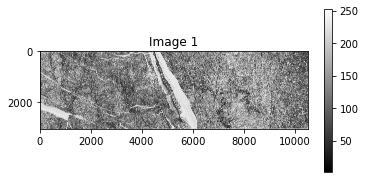

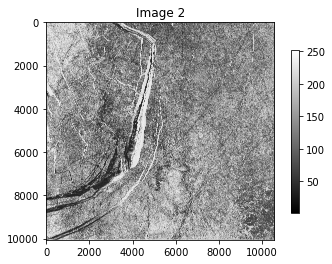

In [13]:
clim = dict()
for s, n in zip(['ft', 'pm'], [n1ft, n1pm]):
    hh = n[1]
    (vmin,), (vmax,) = Figure(hh).clim_from_histogram(ratio=.9)
    clim[s] = (vmin, vmax)
for i, n in enumerate([n1ft,n2ft]):
    hh = n[1]
    plt.imshow(hh, cmap='gray', clim=clim['ft'])
    plt.colorbar(shrink=0.75)
    plt.title(f'Image {i+1}')
    plt.show()

Overlap = 0.9795868745653787


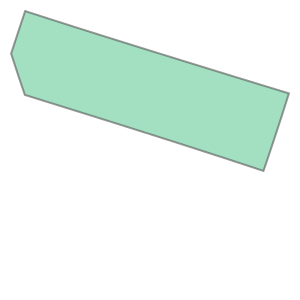

In [14]:
#calc overlap
lon1b, lat1b = n1ft.get_border()
lon2b, lat2b = n2ft.get_border()

proj = get_proj()
x1b, y1b = proj(lon1b, lat1b)
x2b, y2b = proj(lon2b, lat2b)
p1 = Polygon([(x, y) for x, y in zip(x1b, y1b)])
p2 = Polygon([(x, y) for x, y in zip(x2b, y2b)])
intersection = p1.intersection(p2)
overlaps = [intersection.area/p.area for p in [p1, p2]]
print(f'Overlap = {np.max(overlaps)}')
intersection

# Feature tracking
Works best with spatial mean removed (use `n1ft`, `n2ft`)

In [15]:
# Run Feature Tracking
# get start/end coordinates in the image coordinate system (colums/rows)
c1, r1, c2, r2 = feature_tracking(n1ft, n2ft, nFeatures=100000, ratio_test=0.6, domainMargin=0)

ORB detector initiated
Key points found: 100000
ORB detector initiated
Key points found: 100000
Domain filter: 100000 -> 99398
Domain filter: 100000 -> 37485
Keypoints matched 15.551960468292236
Ratio test 0.600000 found 34 keypoints
MaxDrift filter: 34 -> 34
LSTSQ filter: 34 -> 34


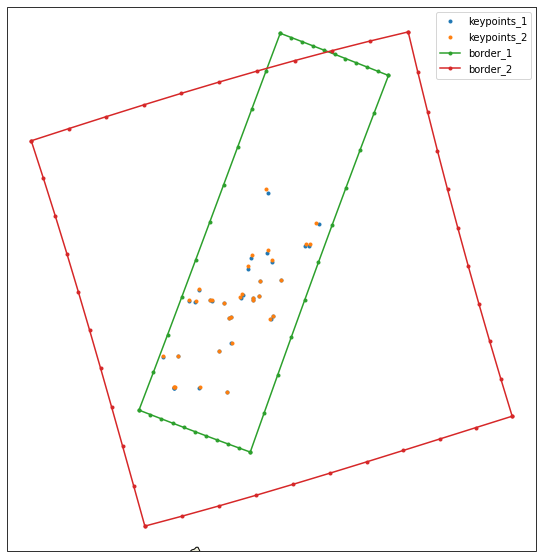

In [16]:
# Plot identified and matched keypoints in geographic coordinates

# convert row/column coordinates of matched features to lon/lat
lon1ft, lat1ft = n1ft.transform_points(c1, r1)
lon2ft, lat2ft = n2ft.transform_points(c2, r2)

# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree())
ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree())
ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())
ax.legend()
plt.show()

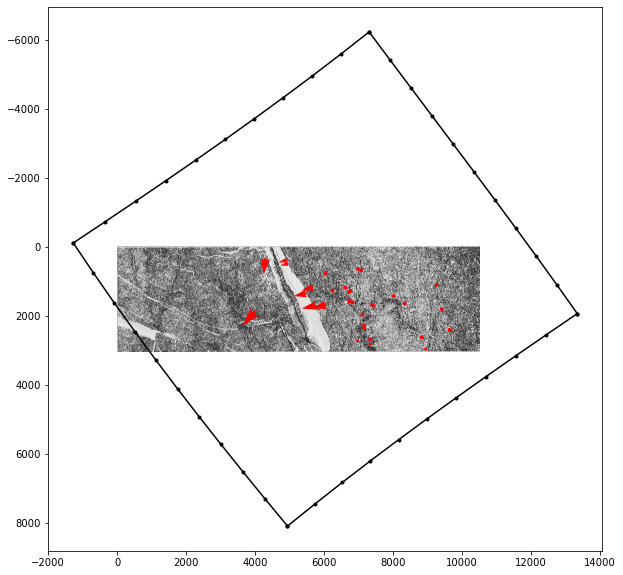

In [17]:
# Plot ice drift on top of image_1

# end points in image_1 coordinate system
n1c2, n1r2 = n1ft.transform_points(lon2ft, lat2ft, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr = n1r2 - r1
dc = n1c2 - c1

# border of image_2 in image_1 coordinate system
n1lon2b, n1lat2b = n1ft.transform_points(lon2b, lat2b, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift
plt.figure(figsize=(10,10))
plt.imshow(n1ft[1], cmap='gray')
plt.quiver(c1, r1, dc, dr, color='r', angles='xy', scale_units='xy', scale=0.2)
plt.plot(n1lon2b, n1lat2b, 'k.-')
plt.show()

# Pattern matching

In [18]:
# Create lon/lat grids in Polar stereographic coordinate system 
# Extent of the grid roughly corresponds to the extent of the image_1

if 0:
    # projection (https://epsg.io/3413)
    srs = NSR(3413)
else:
    proj = get_proj()
    srs_pm = proj.srs
    srs = NSR(srs_pm)

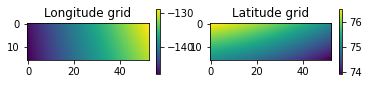

In [19]:
# lon/lat grids for image_1
lon1pm, lat1pm = n1ft.get_geolocation_grids(200)
plt.subplot(1,2,1);plt.imshow(lon1pm);plt.colorbar(shrink=0.3);plt.title('Longitude grid')
plt.subplot(1,2,2);plt.imshow(lat1pm);plt.colorbar(shrink=0.3);plt.title('Latitude grid')
plt.show()

In [20]:
# Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Stereographic projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(
    lon1pm, lat1pm, n1pm, c1, r1, n2pm, c2, r2,
    min_border=300, max_border=300,
    img_size=50, srs=srs_pm)

96% 03810.2 02996.0 02157.5 05353.5 +03.0 0.23 3.437
 Pattern matching - OK! ( 18 sec)


In [21]:
# compute ice drift speed [m/s]
delta_t = (n2ft.time_coverage_start - n1ft.time_coverage_start).total_seconds()
u = upm / delta_t
v = vpm / delta_t
# start points in stereoprojection
x1pm, y1pm = proj(lon1pm, lat1pm)
# end points in lon,lat
lon1pm_u, lat1pm_u = proj(x1pm + upm, y1pm + vpm, inverse=True)

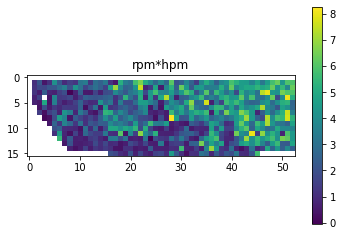

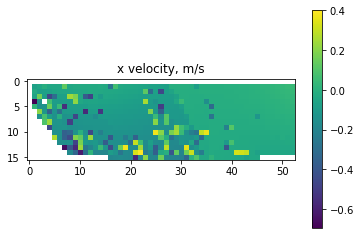

In [22]:
# quality (correlation * peakiness)
plt.imshow(rpm*hpm)
plt.colorbar()
plt.title('rpm*hpm')
plt.show()
#
plt.imshow(u)
plt.title('x velocity, m/s')
plt.colorbar()

# Plotting

In [23]:
# plot domain (and export?)
res = 2000 #m
xmin, xmax, ymin, ymax = get_bbox(proj)
d = Domain(srs_pm, '-te %f %f %f %f -tr %f %f' % (xmin, ymin, xmax, ymax, res, res))
d_extent = [xmin, xmax, ymin, ymax]

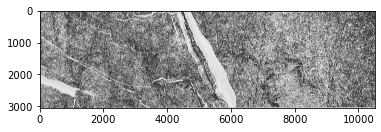

(280.0, 110.0)

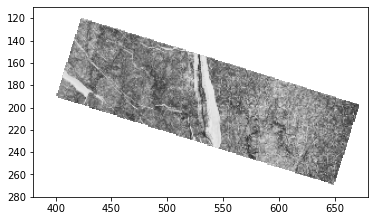

In [24]:
# n1ft_pro = get_projected_hh(n1ft, d)# nearest neighbour
n1ft_pro = get_projected_hh(n1ft, d, resample_alg=1)#1:bilinear - better than NN, tps=True
n1ft_pro[n1ft_pro==0] = np.nan
# n1ft_pro = get_projected_hh(n1ft, d, tps=True)
plt.imshow(n1ft[1], clim=clim['ft'], cmap='gray')
plt.show()
plt.imshow(n1ft_pro, clim=clim['ft'], cmap='gray')
plt.xlim([380,680])
plt.ylim([280,110])

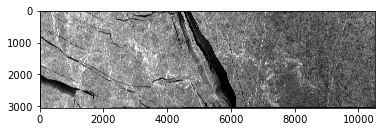

(280.0, 110.0)

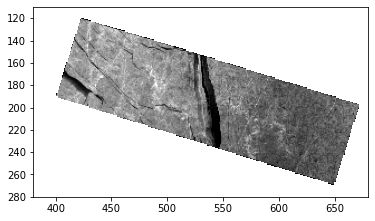

In [25]:
n1pm_pro = get_projected_hh(n1pm, d, resample_alg=1)
n1pm_pro[n1pm_pro==0] = np.nan
plt.imshow(n1pm[1], clim=clim['pm'], cmap='gray')
plt.show()
plt.imshow(n1pm_pro, clim=clim['pm'], cmap='gray')
plt.xlim([380,680])
plt.ylim([280,110])

In [26]:
# get cartopy projection object
print('Plot projection:\n' + srs.wkt + '\n')
globe = ccrs.Globe(semimajor_axis=6378273, semiminor_axis=6356889.44891059)
crs = ccrs.Stereographic(central_latitude=72.125, central_longitude=-137.85,
                         scale_factor=1, globe=globe)

Plot projection:
PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6378273,298.279409875886]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Stereographic"],PARAMETER["latitude_of_origin",72.125],PARAMETER["central_meridian",-137.85],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=stere +lat_0=72.125 +lat_ts=72.125 +lon_0=-137.85 +x_0=0 +y_0=0 +a=6378273 +b=6356889.44891059 +units=m +no_defs"]]



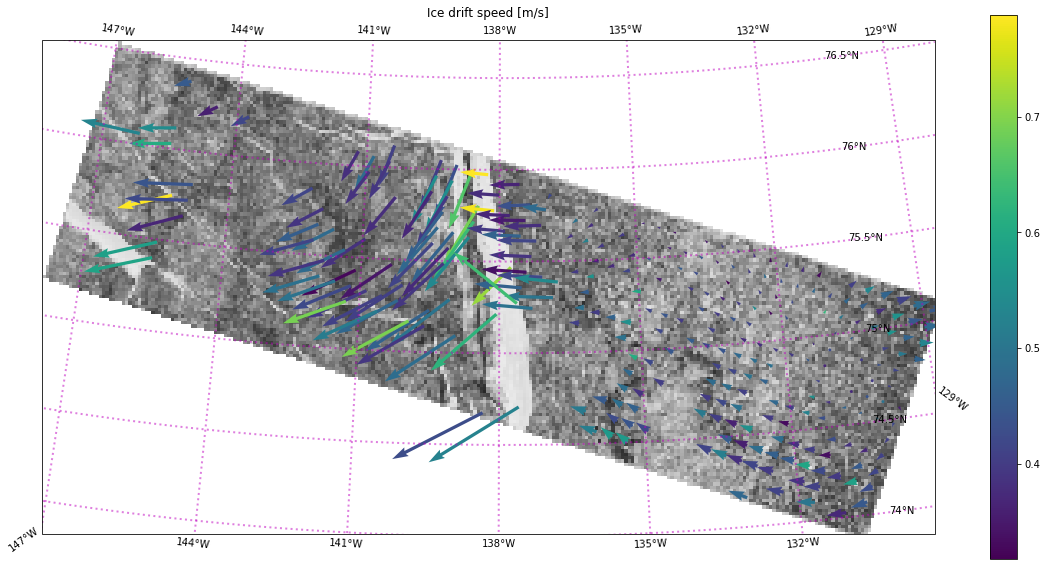

In [27]:
# plot valid vectors in stereographic projection
gpi = (rpm*hpm > 3.5) 

plt.figure(figsize=(20,20))
ax = plt.axes(projection=crs)

im = ax.imshow(
    #n1pm_pro, clim=clim['pm'],
    n1ft_pro, clim=clim['ft'],
    cmap='gray', origin='upper',
    zorder=0, extent=d_extent)
# plt.colorbar(im, shrink=0.5)
quiv=ax.quiver(x1pm[gpi], y1pm[gpi], u[gpi], v[gpi], rpm[gpi], scale=2)
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drift speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
# ax.set_xticks([-300000, -100000, 0, 100000, 300000])
# ax.set_yticks([-700000, -500000, -300000])

ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])

ax.gridlines(linewidth=2, color='m', 
    draw_labels=True, alpha=0.5, linestyle=':')
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
plt.show()

In [28]:
## Generate test files for simple.py
"""
filenames = [
    'S1B_EW_GRDM_1SDH_20200123T120618_20200123T120718_019944_025BA1_D4A2.SAFE',
    'S1B_EW_GRDM_1SDH_20200125T114955_20200125T115055_019973_025C81_EC1A.SAFE'
]
crop_params = [
    (1800,4400,1000,1000),
    (2400,4600,1000,1000),
]

for f,c in zip(filenames, crop_params): 
    n = Nansat(f)
    n.reproject_gcps()
    n.vrt.tps = True
    n.crop(*c)
    n.export(f[:32]+'.tif', bands=['sigma0_HV'], driver='GTiff')
#"""

"\nfilenames = [\n    'S1B_EW_GRDM_1SDH_20200123T120618_20200123T120718_019944_025BA1_D4A2.SAFE',\n    'S1B_EW_GRDM_1SDH_20200125T114955_20200125T115055_019973_025C81_EC1A.SAFE'\n]\ncrop_params = [\n    (1800,4400,1000,1000),\n    (2400,4600,1000,1000),\n]\n\nfor f,c in zip(filenames, crop_params): \n    n = Nansat(f)\n    n.reproject_gcps()\n    n.vrt.tps = True\n    n.crop(*c)\n    n.export(f[:32]+'.tif', bands=['sigma0_HV'], driver='GTiff')\n#"

# Deformation calculation

In [29]:
e1, e2, e3, tri_a, tri_p, triangles = get_deformation_nodes(x1pm[gpi], y1pm[gpi], u[gpi], v[gpi])
# convert deformations to %/day
e1 *= 8640000
e2 *= 8640000
e3 *= 8640000
print(f'Shear min, max: {e1.min()}, {e1.max()}')
print(f'Divergence min, max: {e2.min()}, {e2.max()}')
print(f'Total deformation min, max: {e3.min()}, {e3.max()}')

Shear min, max: -1196.0113130287853, 35650.52774257261
Divergence min, max: 0.01323830081490229, 38241.54130422214
Total deformation min, max: 0.5263086063634459, 52281.6947855219


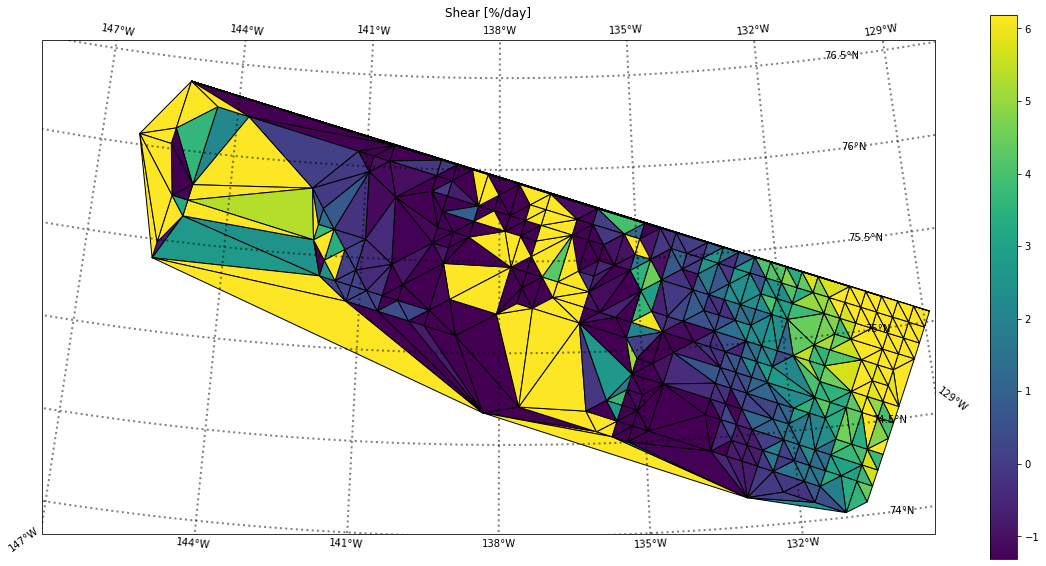

In [30]:
vmin, vmax = np.percentile(e1, [20,80])
plt.figure(figsize=(20,20))
ax = plt.axes(projection=crs)
im = ax.tripcolor(x1pm[gpi], y1pm[gpi],
                  triangles=triangles, facecolors=e1,
                  vmin=vmin, vmax=vmax,
                  edgecolors='k', linewidth=1)
plt.colorbar(im, shrink=0.5)
plt.title('Shear [%/day]')
ax.add_feature(land_50m, edgecolor='black')

ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])

ax.gridlines(linewidth=2, color='black', 
    draw_labels=True, alpha=0.5, linestyle=':')
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
plt.show()

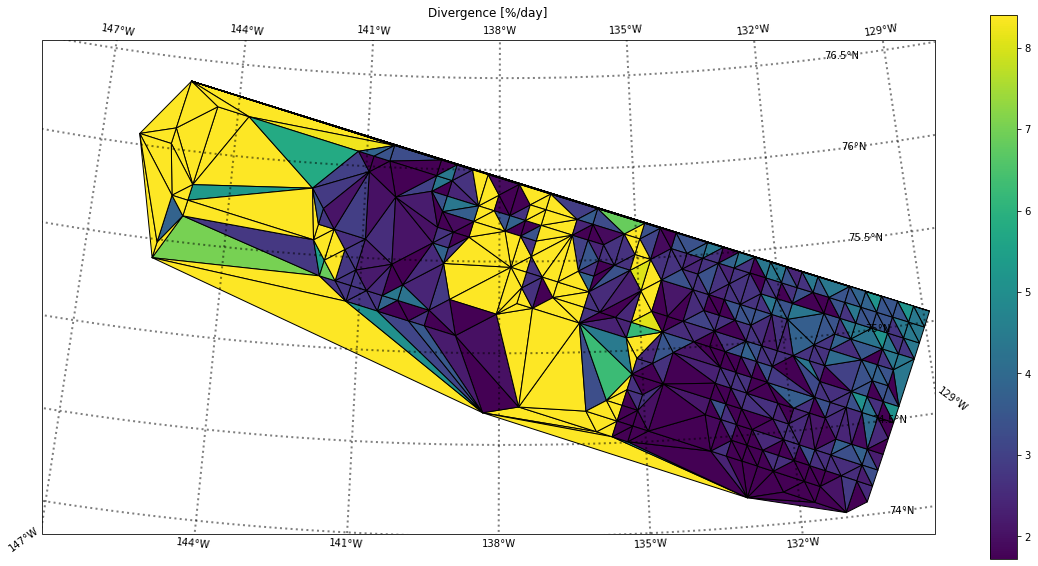

In [31]:
vmin, vmax = np.percentile(e2, [20,80])
plt.figure(figsize=(20,20))
ax = plt.axes(projection=crs)
im = ax.tripcolor(x1pm[gpi], y1pm[gpi],
                  triangles=triangles, facecolors=e2,
                  vmin=vmin, vmax=vmax,
                  edgecolors='k', linewidth=1)
plt.colorbar(im, shrink=0.5)
plt.title('Divergence [%/day]')
ax.add_feature(land_50m, edgecolor='black')

ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])

ax.gridlines(linewidth=2, color='black', 
    draw_labels=True, alpha=0.5, linestyle=':')
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
plt.show()

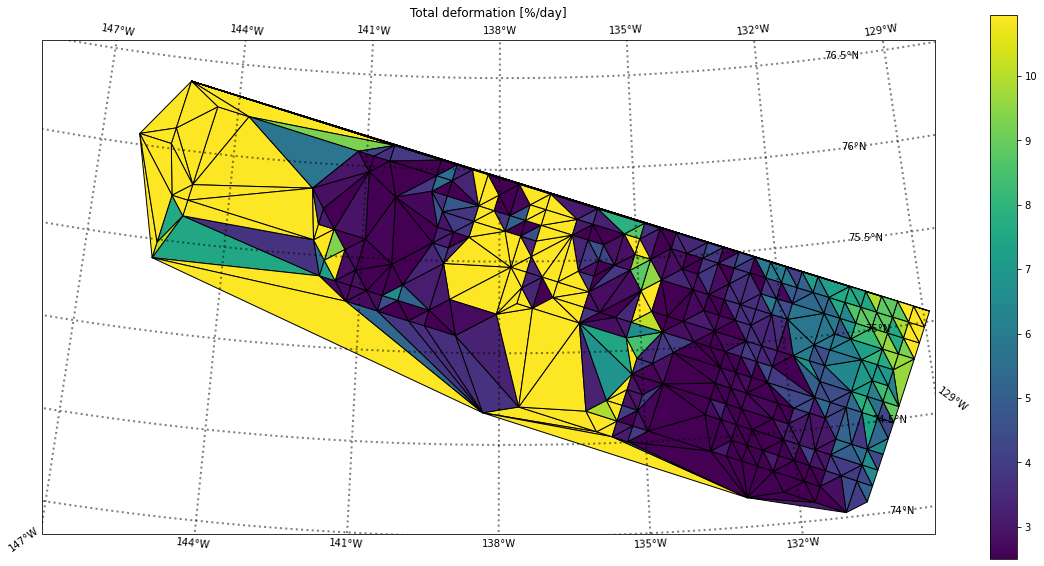

In [32]:
vmin, vmax = np.percentile(e3, [20,80])
plt.figure(figsize=(20,20))
ax = plt.axes(projection=crs)
im = ax.tripcolor(x1pm[gpi], y1pm[gpi],
                  triangles=triangles, facecolors=e3,
                  vmin=vmin, vmax=vmax,
                  edgecolors='k', linewidth=1)
plt.colorbar(im, shrink=0.5)
plt.title('Total deformation [%/day]')
ax.add_feature(land_50m, edgecolor='black')

ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])

ax.gridlines(linewidth=2, color='black', 
    draw_labels=True, alpha=0.5, linestyle=':')
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

plt.show()